# Calculate Job Power Schedules with ILP

This program is designed to take in n number of distinct power scheduling jobs and determine their ideal ordering in to minimize the peak amount of power demand above a provided resource curve. 
\
Becuase this it an ILP program, it will find the optimal solution to the problem, but will take greater than polynomial time to do so. 


In [152]:
import cplex
import json
import matplotlib.pyplot as plt
import numpy as np

# Generate Jobs and Decision Variables
We need to generate the jobs, decision variables and extract other information that will be necessary for the ILP to run

The Jobs used for the ILP will be instantiated here. Each job will have the following format:
\
\
&emsp;&emsp;**release** -> The minimum time that a specific job can begin by. A job can begin no earlier than the release time \
&emsp;&emsp;**deadline** -> The maximum time that a job must complete by. A job can end no later than the deadline time \
&emsp;&emsp;**duration** -> The length (in minutes) that a task will need to complete \
&emsp;&emsp;**height** -> The amount of consistent power that a task will require

In [153]:
jobs = [ 
    {'release' : 0, 'deadline' : 4, 'duration' : 2, 'height' : 1},  
    {'release' : 1, 'deadline' : 6, 'duration' : 1, 'height' : 2},
    {'release' : 3, 'deadline' : 8, 'duration' : 2, 'height' : 1},
    {'release' : 4, 'deadline' : 6, 'duration' : 2, 'height' : 2},
    {'release' : 0, 'deadline' : 5, 'duration' : 1, 'height' : 1},
    {'release' : 3, 'deadline' : 7, 'duration' : 1, 'height' : 1},
    {'release' : 5, 'deadline' : 7, 'duration' : 1, 'height' : 3},
    {'release' : 0, 'deadline' : 8, 'duration' : 1, 'height' : 2},
]

start_time = 0
end_time = 9


In [154]:
# This creates j number of distinct sub-lists where j is the number of jobs
# Each sublist contains all of the finite possible intervals during which job j could be executed
intervals = [[] for _ in range(len(jobs))]
for i, job in enumerate(jobs):
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['duration']
    num = release

    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

# This establishes the height of each job
# This can be accessed later during the execution of the linear program
height = [job['height'] for job in jobs]

# This represents each distinct time step
# It could be easily replaced with a set integer representing the number of time steps
# In a certain period
num_time_steps = end_time - start_time

# This list will represent the value of the resource curve at each distinct time step
# However, for now, it will be left 0 for all time steps for the purposes of debugging
# resources = [0 for _ in range(num_time_steps)]
resources = [0, 2, 3, 2, 4, 4, 3, 1, 1]

This creates a list of objects with the form {'name': x_i_j, value: ?} where each name is a distinct time interval for a distinct job. These will represent all of the decision variables for the ILP.
\
\
Specifically, this is saying that decision variable x_i_j is the ith possible interval for job j where the value is the actual interval of time steps. This is stored here so we don't have to repeatedly query the intervals list

In [155]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# This is the name of the objective variable that we will minimize
objective_variable = 'd'

# Solve the ILP
Set up the necessary equations and constraints in order to solve the ILP problem

In [156]:
# Create the cplex problem
problem = cplex.Cplex()
problem.set_problem_type(cplex.Cplex.problem_type.LP)
problem.set_results_stream(None)

# Maximize objective
problem.objective.set_sense(problem.objective.sense.minimize)

# This retrieves the names of all of the decision variables 
names = [variable['name'] for variable in decision_variables] + [objective_variable]

# these are the other parameters needed to form the basis of the linear programming problem
obj = [0 for _ in range(len(decision_variables))] + [1]# only minimizing d
lb = [0 for _ in range(len(decision_variables))] + [0]
ub = [1 for _ in range(len(decision_variables)) ] + [sum(height)]

# Establish the problem
types = [problem.variables.type.integer] * (len(decision_variables)) + [problem.variables.type.continuous]
problem.variables.add(obj=obj, lb=lb, ub=ub, types=types, names=names)

range(0, 33)

This will generate the first set of constraints

This for loop adds the constraints that make it so that a job can run during only one interval. So for each job, aggregate all of the decision variables that correspond to each possible execution interval for that job. Then specify that they all of those decision variables can only add up to one  

In [157]:
curr_index = 0
for i, interval in enumerate(intervals):
    if i == 0:
        variables = decision_variables[i : i + len(interval)]
        variables = [v['name'] for v in variables]
        curr_index += len(interval)
    elif i > 0:
        variables = decision_variables[curr_index : curr_index + (len(interval))]
        variables = [v['name'] for v in variables]
        curr_index += len(interval)
    
    # The coefficient of each decision variable is one
    constraints = [1 for _ in range(len(variables))]

    # This is saying that the sum of each of the decision variabels can only equal one
    problem.linear_constraints.add(
        lin_expr=[ [ variables, constraints ] ],
        senses=['E'],
        rhs=[1]
    )

This generates the second set of constraints 
\
\
It aggregates all of the desicion variables that correspond to intervals that could possibly be running during that time step. /
It then aggregates the heights corresponding to the jobs that each decision variable represents. 
It multiplies those heights by the decision variables. However, the constrain ensures that the total sum is less than the max height d

In [158]:
for i in range(num_time_steps):
    use_variables = []
    use_height = []

    for variable in decision_variables:
        
        # Check the interval times of the corresponding variable
        # Then check if the current timestep falls within that interval
        job_interval_start, job_interval_end = variable['value'][0] - start_time, variable['value'][1] - start_time

        # if i >= job_interval_start and i <= job_interval_end: #COME BACK TO THIS
        if job_interval_start <= i < job_interval_end:
            job_id = int(variable['name'].split('_')[-1])

            use_height.append(height[job_id])
            use_variables.append(variable['name'])

    # Add d to the decision variables 
    use_variables.append('d')
    use_height.append(-1)

    # print(use_variables, use_height)

    # Add the linear constraint to the problem
    problem.linear_constraints.add(
        lin_expr=[ [ use_variables, use_height ] ],
        senses=['L'],
        rhs=[resources[i]]
    )

# Solve the ILP problem

Use CPLEX to solve the formulated ILP problem and then use post processing to extract the intervals each job will run in.

In [159]:
problem.solve()

# --- Output solution ---
solution = problem.solution
print("Status:", solution.get_status_string())
print("Objective value:", solution.get_objective_value())

# for name in names:
#     val = solution.get_values(name)

#     if val == 1 and name != 'd':

#         job_id = int(name.split('_')[-1])
#         interval_id = int(name.split('_')[1])
#         print(f"Job {job_id} interval: {intervals[job_id][interval_id]}")

Status: integer optimal solution
Objective value: 0.0


# Plot the Jobs

Use Matplotlib to plot the jobs on a curve

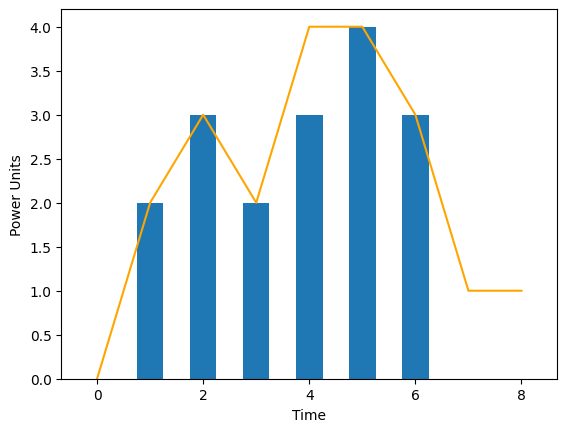

In [160]:
final_heights = [0 for _ in range(num_time_steps)]
for name in names:
    val = solution.get_values(name)

    if val == 1 and name != 'd':
        job_id = int(name.split('_')[-1])
        interval_id = int(name.split('_')[1])
        interval = intervals[job_id][interval_id]
    
        for i in range(interval[0], interval[1]):
            final_heights[i] += height[job_id]


job_graph_xvalues = np.array([i for i in range(num_time_steps)])
job_graph_yvalues = np.array(final_heights)

plt.bar(job_graph_xvalues, job_graph_yvalues, label="jobs", width=0.5)
plt.plot(job_graph_xvalues, resources, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")

plt.show()